## Online banking fraud detection using natural language processing techniques

**Team 9:**

- Latif Masud
- ​Wesley Mitchell
- Gerald Wagner​

**Course:** AI 574 – Natural Language Processing (Spring 2025)

### Problem Statement
* This project aims to identify fraudulent activity in online banking transactions using Natural Language Processing techniques. Online banking activity can be monitored by the webpages or API endpoints a user interacts with throughout their entire session history. With this sequence of user actions, a binary classification can be trained such that it labels the activity as valid or fraudulent; if fraudulent, remediation steps could then be implemented such as denying the transaction. With online banking a staple of people every day financial lives and 100's of millions of dollars transacted daily, identifying fraudulent activity is of upmost importance to prevent unnecessary monetary losses for both individuals and financial institutions.
    
* **Keywords:** Online banking, fraud, fraud detection, financial industry 

### Data Collection

* Source(url): https://github.com/pboulieris/FraudNLP/blob/master/Fraud%20Detection%20with%20Natural%20Language%20Processing.rar
* Short Description: The data set of 105,303 online banking transactions with 9 transaction characteristics:
    * Action time mean: the average time between actions in a transaction
    * Action time std: the standard deviation of the time between actions
    * log(amount): the natural logarithm of the transaction amount
    * Transaction Type: a string indicating whether the transaction is fraudulent or not
    * time_to_first_action: the time between the start of the transaction and the first action taken
    * actions_str: a string containing the names of all actions taken in the transaction
    * total_time_to_transaction: the total time elapsed from the start of the transaction to its completion

* Keywords: bank transactions, user actions, API endpoints, webpage urls, dollar amount

### Required packages

* the following packages are required to run this notebook:
    * pandas
    * scikit-learn
    * nltk
    * matplotlib

Install by creating and activating a virtual environment, then installing via the pip command:

!pip install pandas scikit-learn nltk matplotlib wordcloud

### Imports

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from nltk import FreqDist
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

### Load the data

In [2]:
# online banking transaction data
path = Path('./data/Fraud Detection with Natural Language Processing.pkl')
df = pd.read_pickle(path)

In [3]:
# vocabulary of API calls
path_vocab = Path('./data/vocab.csv')
df_vocab = pd.read_csv(path_vocab)

### Exploratory data analysis (EDA)

In [4]:
df.shape

(105303, 9)

In [5]:
df.head(10)

,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud
0,"[[2], [23], [6], [7], [14], [25], [28], [6], [...","[0, 47000.0, 640000.0, 6000.0, 54000.0, 10000....",203,15,1.000000,1.000000,1.000000,1.0,0
1,"[[22], [27], [24], [1], [1268], [1269], [1267]...","[0, 33204.0, 215636.0, 443415.0, 72586.0, 3424...",203,13,1.000000,1.000000,0.500000,1.0,0
2,"[[22], [24], [27], [1], [1268], [1269], [1267]...","[0, 25459.0, 46236.0, 428626.0, 42785.0, 74158...",359,310,1.000000,0.333333,0.333333,1.0,0
3,"[[22], [1], [29], [22], [26], [2], [23], [25],...","[0, 440927.0, 5785.0, 46875.0, 968650.0, 31175...",250,350,1.000000,0.500000,0.500000,1.0,0
4,"[[22], [24], [27], [72], [1269], [1268], [1267...","[0, 93894.0, 46810.0, 548388.0, 132548.0, 3784...",203,350,1.000000,0.600000,0.400000,1.0,0
5,"[[22], [24], [27], [23], [2], [1269], [1269], ...","[0, 921997.0, 47386.0, 963970.0, 9522.0, 44359...",593,2000,1.000000,0.666667,0.166667,1.0,1
6,"[[22], [47], [24], [27], [41], [2], [23], [6],...","[0, 48869.0, 843763.0, 138682.0, 203156.0, 944...",124,80,0.142857,0.142857,0.285714,1.0,0
7,"[[37], [37]]","[0, 941710.0]",656,80,0.250000,0.250000,0.375000,1.0,0
8,"[[10], [56], [12], [121], [13], [52], [19], [8...","[0, 437000.0, 93000.0, 860000.0, 14000.0, 1000...",595,135,1.000000,1.000000,1.000000,1.0,0
9,"[[25], [4], [5], [24], [27], [41], [45], [4], ...","[0, 31238.0, 141391.0, 5510.0, 10000.0, 280000...",468,154,1.000000,1.000000,1.000000,1.0,0


In [6]:
df.describe()

,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud
count,105303.000000,1.053030e+05,105303.000000,105303.000000,105303.000000,105303.000000,105303.000000
mean,655.664236,4.687915e+02,0.706309,0.259218,0.406677,0.896871,0.000959
std,1367.867413,7.095939e+03,0.349859,0.307056,0.305293,0.218759,0.030955
min,15.000000,0.000000e+00,0.000960,0.000946,0.000954,0.002433,0.000000
25%,359.000000,3.700000e+01,0.400000,0.047619,0.142857,0.945455,0.000000
50%,623.000000,1.000000e+02,0.910256,0.120370,0.333333,1.000000,0.000000
75%,795.000000,2.400000e+02,1.000000,0.333333,0.641026,1.000000,0.000000
max,127578.000000,1.500000e+06,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
df.dtypes

actions              object
times                object
execution_time        int64
Amount                int32
device_freq         float64
ip_freq             float64
beneficiary_freq    float64
application_freq    float64
is_fraud              int64
dtype: object

In [8]:
df.groupby('is_fraud').describe()

execution_time                                                      \
                  count        mean          std   min    25%    50%    75%   
is_fraud                                                                      
0              105202.0  655.652336  1368.497015  15.0  359.0  623.0  795.0   
1                 101.0  668.059406   277.834621  93.0  453.0  656.0  812.0   

                      Amount                ... beneficiary_freq       \
               max     count          mean  ...              75%  max   
is_fraud                                    ...                         
0         127578.0  105202.0    457.337180  ...         0.641509  1.0   
1           1937.0     101.0  12399.673267  ...         0.166667  1.0   

         application_freq                                                     \
                    count      mean       std       min       25%   50%  75%   
is_fraud                                                                       
0                105202.0  0.897077  0.218437  0.002433  0.945946  1.00  1.0   
1                   101.0  0.682153  0.387336  0.005291  0.279503  0.95  1.0   

               
          max  
is_fraud       
0         1.0  
1         1.0  

[2 rows x 48 columns]

In [9]:
df_vocab.head()

,Name
0,/ACCOUNTS/ACCOUNTS_FULL_EXCHANGE
1,/PROFILE/USERPROFILE
2,/P2PREGISTRATION/ASKMEMBER
3,/CARDS/FETCHCARDS
4,/ACCOUNTS/ACCOUNTS_FULL


In [10]:
df_vocab.shape

(1916, 1)

In [11]:
df_vocab.describe()

,Name
count,1916
unique,1916
top,/API/WHITELIST/PRODUCTS_LIST
freq,1


EDA Summary

- the transaction dataset contains 105303 online banking transactions
- of the 105303 transactions, 105202 are valid while only 101 are fraudulent
    - this is a severe class imbalance that will have to be handled in the neural network architecture
- there are 9 attributes for each banking transaction:
    - a label for trasactions that are valid or fraudulent (0 or 1 respectively)
    - list of user actions encoded as a list of integers which corresponds to the vocabulary dataframe
    - list of times in ms for each user action to occur
    - the total elapsed time of the transaction in ms
    - Recency, Frequency, and Monetary features:
        - the transaction amount in log(Euros)
        - the device characteristics
        - the IP address of the user
        - the beneficiary's frequency of conducting a transaction
        - the applications used for the transaction (i.e., Android or iOS)
- there also exists a vocabulary dataset which contains a list of API endpoints/webpage urls which a user can access
    - these are used to translate the encoded user action column of the transaction dataset back to the original url's
    - there are 1916 total endpoints/url's, all of which are unique
    - the index of the dataframe corresponds to the id value used in the user action list from the transaction dataframe

### Data Preprocessing

* Enumerate and present the main steps you preformed in the data preprocessing
* Add your code and interpret the outcome of main steps/functions

In [12]:
# dictionary mapping ids in transaction data to vocabulary
vocab = df_vocab['Name'].to_list()

vocab_sentences = []
for endpoint in vocab:
    sentence = endpoint.replace('/', ' ').lstrip().lower() + ' .'
    vocab_sentences.append(sentence)

id_to_action = {i:a for i, a in enumerate(vocab_sentences)}

In [13]:
# convert the tokenized user actions during online banking to API endpoint calls
actions_raw = df['actions'].to_list()

actions = []
for action in actions_raw:

    action_str = (action.replace('[', '')
           .replace(']', '')
           .replace(' ', '')
           .split(','))
    
    action_ids = []
    for id in action_str:
        if id:
            
            action_ids.append(id_to_action[int(id)])

    actions.append(' '.join(action_ids))

<Axes: xlabel='Samples', ylabel='Counts'>

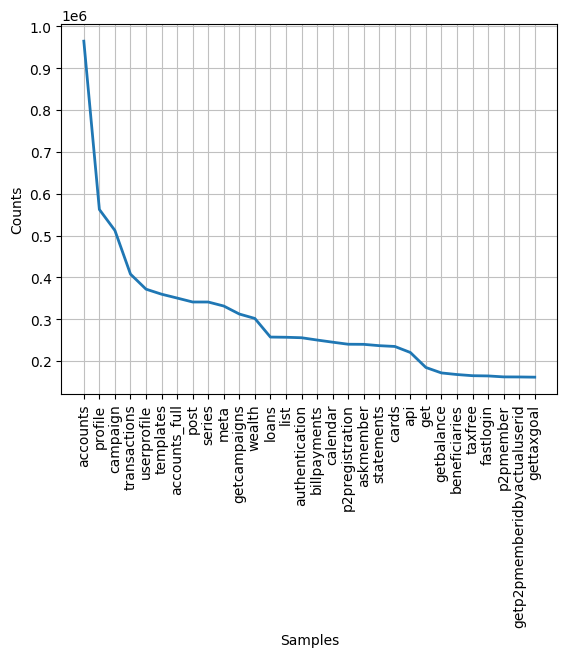

In [14]:
# plot the words to see most frequent
word_list = ' '.join(actions).replace(' . ', ' ').split()
fdist = FreqDist(word_list[2:])
fdist.plot(30)

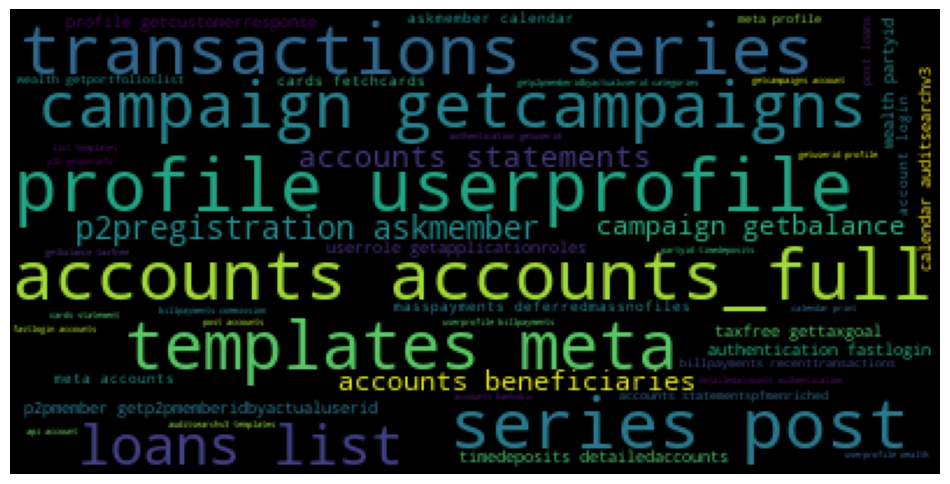

In [15]:
# create wordcloud to visualize popular words
wordcloud = WordCloud().generate(' '.join(word_list))

plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [16]:
sequence_length = [len(s.split()) for s in actions]

Text(0, 0.5, 'Number of Sentences')

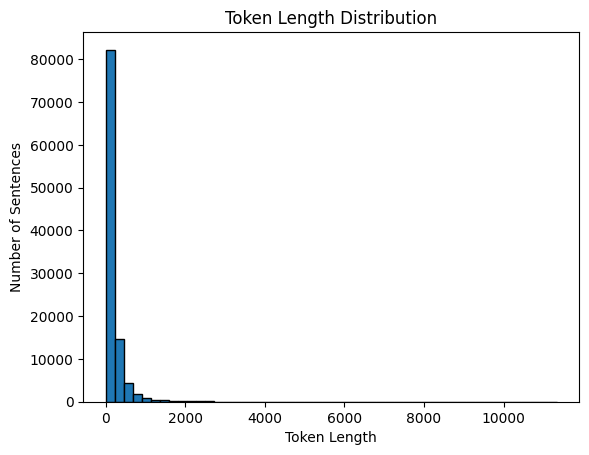

In [17]:
fig = plt.hist(sequence_length, bins = 50, edgecolor = 'black')
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Number of Sentences')

In [18]:
# create an array of labels
labels = df['is_fraud'].to_list()

print(f'there are {sum(labels)} fraudulent transactions')
print(f'which is only {sum(labels)/len(labels)*100:0.2f}% of the total transactions')

there are 101 fraudulent transactions
which is only 0.10% of the total transactions


In [19]:
# seperate the data into training and testing datasets
# enable the stratify option to ensure there are proportional amounts of fraudulent transactions in the training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(actions, labels, test_size=0.2, shuffle=True, stratify=labels)

In [20]:
print(sum(y_train))
print(sum(y_test))

81
20


### Methodology

1. Explan your Deep Learning process / methodology



2. Introduce the Deep Neural Networks you used in your project
 * Model 1
    * Description 
 
 * Model 2
    * Description
 
 * Ensemble method
     * Description 
 
 
3. Add keywords  
**Keywords:** natural language processing, sentiment analysis, clustering, binary classification, multi-label classification, prediction
	___
 **Example**
* ConvNet
    * A convolutional neural network (CNN, or ConvNet) is a class of deep neural networks, most commonly applied to analyzing visual imagery(source Wikipedia). 
 
* **Keywords:** supervised learning, classification, ...

In [21]:
# TODO: Add code

### Model Fitting and Validation

1. model 1 
    - decription 
2. model 2
    - decription 

In [22]:
# TODO: Add Code

### Model Evaluation 

* Examine your models (coefficients, parameters, errors, etc...)

* Compute and interpret your results in terms of accuracy, precision, recall, ROC etc. 

In [23]:
# TODO: Add code

### Issues / Improvements
1. Dataset is very small
2. Use regularization / initialization
3. Use cross-validaiton
4. ...

###  References
   - Academic (if any)
   - Online (if any)
	

### Credits

- If you use and/or adapt your code from existing projects, you must provide links and acknowldge the authors. Keep in mind that all documents in your projects and code will be check against the official plagiarism detection tool used by Penn State ([Turnitin](https://turnitin.psu.edu))

> *This code is based on .... (if any)*